In [1]:
%%capture
!pip install pytorch-ignite
!git clone https://github.com/karaposu/SkinDetectionExamples.git
%cd SkinDetectionExamples/src



# Imports

In [2]:
from typing import List
from typing import Dict
import itertools
import torch
import cv2
import numpy
from google.colab.patches import cv2_imshow

import pathlib
import functools

import torch
from torchvision import transforms
from google.colab.patches import cv2_imshow

from bisenetv2 import BiSeNetV2
from visualisation import draw_results
import matplotlib.pyplot as plt

from PIL import Image as im
import cv2
import numpy as np
import skimage.exposure

# Helper Functions

In [3]:
def draw_results(image: torch.Tensor,
                 mask: torch.Tensor,
                 
                 img_mean=(0.485, 0.456, 0.406),
                 img_std=(0.229, 0.224, 0.225)):
  
    assert image.shape[1:] == mask.shape[1:]
    assert mask.dtype == torch.bool

    image = image.cpu().numpy()
    image = numpy.transpose(image, (1, 2, 0))
    image = (image * img_std) + img_mean
    image = (255 * image).astype(numpy.uint8)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    mask = mask.cpu().numpy()


def load_image(image_path):
    image = cv2.imread(image_path)
    assert image is not None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_width = (image.shape[1] // 32) * 32
    image_height = (image.shape[0] // 32) * 32

    image = image[:image_height, :image_width]
    return image

# from imutils import face_utils
# import dlib









# Methods 

## 1_WillBrennan/SemanticSegmentation

### Load Pretrained Model 

In [ ]:
modelweight="data/model_segmentation_realtime_skin_30.pth"
state_dict = torch.load(modelweight,map_location=torch.device('cpu'))

model = BiSeNetV2(['skin'])
model.load_state_dict(state_dict)

model.eval()

### Experiment

In [5]:
def transform_img_for_model(img):
        image_width = (img.shape[1] // 32) * 32
        image_height = (img.shape[0] // 32) * 32
       
        resized_image = cv2.resize(img, (image_width,image_height), interpolation = cv2.INTER_AREA)
       
 
        fn_image_transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ])

        transformed_image = fn_image_transform(resized_image)
       
        return transformed_image, resized_image

In [33]:
def create_skin_mask(img):

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        transformed_image,resized_image=transform_img_for_model(img)
        transformed_image=transformed_image
        # print(transformed_image.shape)
        # cv2.imwrite("c.jpg",transformed_image ) 

        with torch.no_grad():
            transformed_image = transformed_image.unsqueeze(0)
            results = model(transformed_image)['out']
            results = torch.sigmoid(results)
            results = results > 0.5
            mask=results[0]
            mask=mask.squeeze(0)
            mask = mask.cpu().numpy()
            mask=mask*255
            mask = mask.astype('uint8')

        resized_mask = cv2.resize(mask, (img.shape[1],img.shape[0]), interpolation = cv2.INTER_AREA)
       

        return resized_mask



(1112, 700)
(1112, 700, 3)


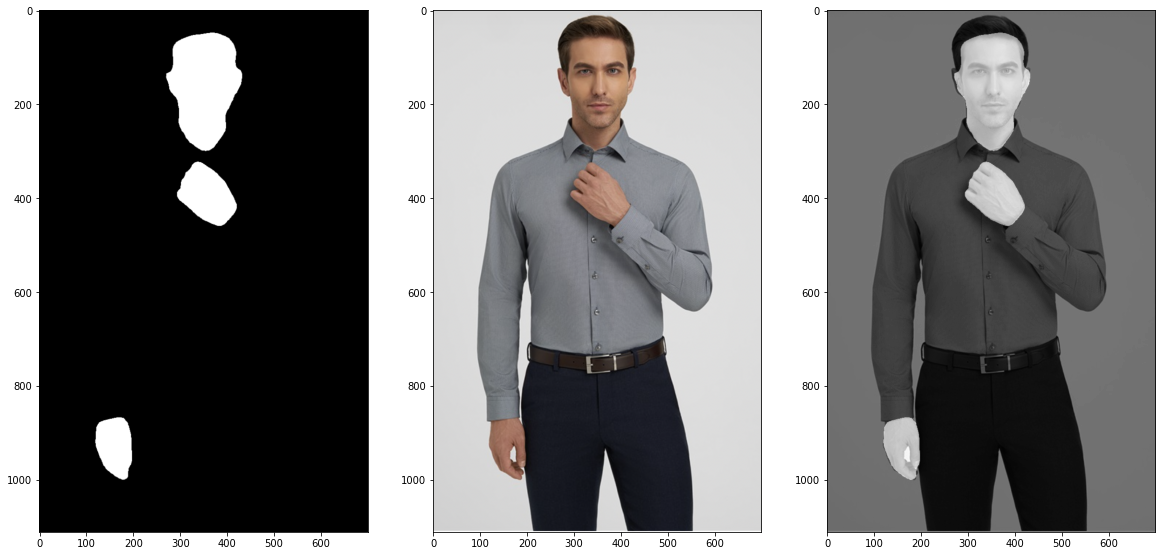

In [36]:
image_path ="data/henderson1.png"
original = cv2.imread(image_path)



resized_mask=create_skin_mask(original)
print(resized_mask.shape)
print(original.shape)


gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
ontop = cv2.addWeighted(resized_mask, 0.5, gray, 0.5, 0)

f, axarr = plt.subplots(1,3,figsize=(20, 15))
axarr[0].imshow(resized_mask, cmap='gray')
axarr[1].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axarr[2].imshow(ontop , cmap='gray')

    


## 2_OpenCV